In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt

In [2]:
from art.attacks.inference import model_inversion
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.fc_1 = nn.Linear(in_features=5 * 5 * 64, out_features=128)
        self.fc_2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 64)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [4]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
print(x_train.shape)


(60000, 28, 28, 1)


In [5]:
# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
print(x_train.shape,x_test.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)


In [6]:
# Step 2: Create the model

model = Net()
device = torch.device('mps')
model.to(device)

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc_1): Linear(in_features=1600, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [9]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=128, nb_epochs=30)

In [10]:
# Step 5: Create the attack object

my_attack = model_inversion.MIFace(classifier, max_iter=10000, threshold=1.)

In [11]:
# Step 6: Create an array of the classes to be attacked

y_all = np.arange(10)
y_all

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
# We will experiment with a number of different initializations:

x_init_average = np.zeros((10, 1, 28, 28),dtype=np.float32) + np.mean(x_test, axis=0)

In [13]:
class_gradient = classifier.class_gradient(x_init_average, y_all)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 1.230004


In [14]:
inferred_images = my_attack.infer(x=x_init_average,y=y_all)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
inferred_images.shape

(10, 1, 28, 28)

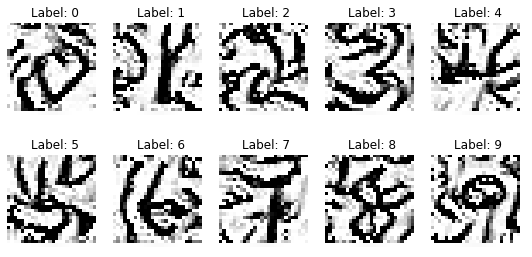

In [16]:
# plot the inverted class representations
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(inferred_images[i,:,:,:].reshape(28,28), cmap=plt.cm.gray_r)
    ax.set_title('Label: {}'.format(y_all[i]))

plt.tight_layout()
plt.show()
